In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. wpd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import gp_minimize


/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
classifier_output = pd.read_csv('/kaggle/input/tractable_ds_excercise_data/classifier_output.csv')
print(f'Classifier output data shape:  {classifier_output.shape}')
classifier_output.head(10)

Classifier output data shape:  (1000000, 4)


,claim_id,part,urr_score,set
0,0,fbumper,0.464102,0
1,0,bbumper,0.680342,0
2,0,bldoor,NaN,0
3,0,brdoor,NaN,0
4,0,frdoor,NaN,0
5,0,fldoor,NaN,0
6,0,frwing,NaN,0
7,0,flwing,NaN,0
8,0,brwing,NaN,0
9,0,blwing,0.899217,0


In [3]:
# Rows with no urr_score aren't needed for this analysis.  We're missing a lot for some reason
classifier_output.dropna(inplace=True)
print(f'Classifier output data shape without nans:  {classifier_output.shape}')

Classifier output data shape without nans:  (682424, 4)


In [4]:
# Get line data

metadata_files = []
for dirname, _, filenames in os.walk('/kaggle/input/tractable_ds_excercise_data/metadata'):
    for filename in filenames:
        metadata_files.append(os.path.join(dirname, filename))

line_data = pd.concat([pd.read_csv(filepath) for filepath in metadata_files])
print(f'Line data shape: {line_data.shape}')
line_data.head(10)

Line data shape: (199827, 10)


,claim_id,make,model,year,poi,line_num,part,operation,part_price,labour_amt
0,42710,Opel,Astra,2011.0,Front Centre,1,fbumper,replace,413.649994,125.000000
1,91687,Ford,Mondeo,2001.0,Left Rear,1,fbumper,repair,NaN,50.000000
2,14084,Volkswagen,Transporter,2008.0,NaN,1,bbumper,repair,NaN,69.999999
3,88262,Citroen,C8,2009.0,Front Centre,1,fbumper,repair,NaN,55.000001
4,6007,Ford,Fusion,2008.0,Rear Right,1,bbumper,repair,NaN,25.000000
5,92167,Renault,Laguna,2006.0,Right Front,2,frwing,repair,NaN,180.000001
6,75641,Opel,Corsa,2008.0,Left Front,1,fbumper,repair,NaN,10.000000
7,51569,Ford,Mondeo,2009.0,Front Centre,1,fbumper,replace,369.170013,115.000004
8,84613,Volkswagen,Golf,1994.0,NaN,1,fbumper,replace,199.949997,0.000000
9,62657,Renault,Megane,2006.0,NaN,2,brdoor,replace,225.000000,199.999994


In [5]:
# We seem to be missing about 5000 of the promised claims - perhaps ones where no repairs or replacements were made

print(f'Unique claims: {len(line_data["claim_id"].unique())}')

Unique claims: 94544


In [6]:
# Merge the claim-level data first, and then the line-level data
claim_merged = classifier_output.merge(line_data[['claim_id', 'make', 'model', 'year','poi']].drop_duplicates(subset=['claim_id'], keep='first'),
                                       how='left', on='claim_id')

print(f'Classifier outputs not associated with a claim: {claim_merged["make"].isna().sum()}')
# Remove any classifier outputs that can't be associated with a claim
claim_merged.dropna(subset=['make'], inplace=True)

data = pd.merge(claim_merged, line_data[['claim_id', 'line_num', 'part', 'operation', 'part_price', 'labour_amt']],
                how='left', on=['claim_id', 'part'])

data['operation'].fillna('undamaged', inplace=True)
print(f'Merge data shape: {data.shape}')
data.head(10)

Classifier outputs not associated with a claim: 35152
Merge data shape: (647272, 12)


,claim_id,part,urr_score,set,make,model,year,poi,line_num,operation,part_price,labour_amt
0,0,fbumper,0.464102,0,Volkswagen,Tiguan,2010.0,Rear Centre,NaN,undamaged,NaN,NaN
1,0,bbumper,0.680342,0,Volkswagen,Tiguan,2010.0,Rear Centre,1.0,replace,266.600006,110.000005
2,0,blwing,0.899217,0,Volkswagen,Tiguan,2010.0,Rear Centre,NaN,undamaged,NaN,NaN
3,1,bbumper,0.790558,0,Peugeot,307,2003.0,Rear Left,1.0,replace,308.920013,55.000002
4,1,bldoor,0.050809,0,Peugeot,307,2003.0,Rear Left,2.0,repair,NaN,55.000001
5,1,fldoor,0.085575,0,Peugeot,307,2003.0,Rear Left,NaN,undamaged,NaN,NaN
6,1,blwing,0.979714,0,Peugeot,307,2003.0,Rear Left,3.0,replace,337.709991,114.999998
7,2,fbumper,0.599913,0,Volkswagen,Vw,2007.0,Front Centre,1.0,replace,294.000000,115.000007
8,2,bbumper,0.645391,0,Volkswagen,Vw,2007.0,Front Centre,NaN,undamaged,NaN,NaN
9,2,bldoor,0.331490,0,Volkswagen,Vw,2007.0,Front Centre,NaN,undamaged,NaN,NaN


In [7]:
# Visualise the effectiveness of the classifier on the test set

data['rounded_urr_score'] = data['urr_score'].apply(lambda x: round(x, 2))

bucket_counts = (data[(data['set']==2)][['rounded_urr_score', 'operation', 'urr_score']]
                 .groupby(['rounded_urr_score', 'operation'])
                 .count()
                 .reset_index()
                 .rename(columns={'urr_score': 'count'})
                 .set_index('rounded_urr_score')
                 .pivot(columns='operation', values='count')
                 .fillna(0)
                )

bucket_counts = bucket_counts[['undamaged', 'repair', 'replace']]

bucket_counts.head(10)

operation,undamaged,repair,replace
rounded_urr_score,,,
0.00,35.0,2.0,0.0
0.01,113.0,3.0,0.0
0.02,159.0,6.0,1.0
0.03,297.0,10.0,0.0
0.04,425.0,17.0,1.0
0.05,616.0,26.0,5.0
0.06,752.0,31.0,4.0
0.07,942.0,40.0,3.0
0.08,1037.0,45.0,5.0


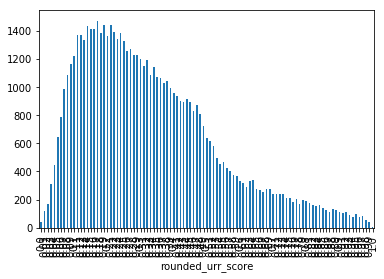

In [8]:
bucket_counts.sum(axis=1).plot.bar()

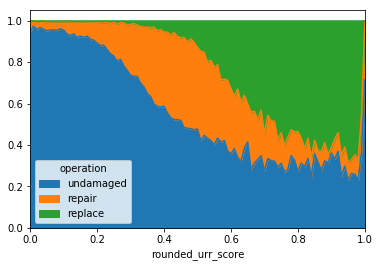

In [9]:
bucket_counts_divided = bucket_counts.divide(bucket_counts.sum(axis=1), axis=0)

bucket_counts_divided.plot.area()

The shape of this chart is in line with expectations except for the fact that a high proportion of the higher values continue to refer to undamaged parts.  I can think of three explanations for this:
* Missing data (action - check supply of data for missing)
* A mistaken classifier that wrongly flags undamaged parts as in need of repair or replacement (action: rebuild classifier - more data, different model, etc)
* A classifier that correctly flags parts that should have been repaired or replaced but haven't (action: manually review bad cases)
* A code mistake on my part (action: get code review)

With more time for this test I'd drill down into which makes and models seem to have the issue.

### Threshold Optimisation

* There are six possible ways of misclassifying operations, and in an ideal world we would put a cost to each of them and optimise on that basis
* But practically, this is hard to do, except in the case of misclassifying repairs as replacement, which could probably be estimated from the cost-of-part data
* So rather than use a domain-specific metric, I'll choose a general one for ordinal regression.
* A quick google search shows a dearth of standard metrics, but [this stackoverflow post](https://stats.stackexchange.com/questions/338904/measures-of-ordinal-classification-error-for-ordinal-regression) links to [this paper](http://www.esuli.it/publications/ISDA2009.pdf) which suggests macroaveraged mae as a good metric for unbalanced classes (which we have here)
* Macroaveraged means you take the mean absolute error for each true class, and then average those
* The thresholds aren't independent, so I'll optimise them together

In [10]:
operation_ranks = {'undamaged': 0,
                   'repair': 1,
                   'replace': 2}

data['operation_rank'] = data['operation'].apply(lambda x: operation_ranks[x])

def mae_single_point(urr_score, operation_rank, repair_threshold, replace_threshold):
    classified_outcome_rank = int(urr_score > repair_threshold) + int(urr_score > replace_threshold)

    return abs(classified_outcome_rank - operation_rank)

assert(mae_single_point(0.9, 0, 0.4, 0.7) == 2)
assert(mae_single_point(0.5, 1, 0.4, 0.7) == 0)
assert(mae_single_point(0.5, 2, 0.4, 0.7) == 1)
    

In [11]:
def mae_dataset(data, repair_threshold, replace_threshold):
    class_maes =[]
    for i in range(2):
        class_data = data[(data['operation_rank']==i)]
        class_mae = sum(class_data
                        .apply(lambda row: mae_single_point(row['urr_score'], row['operation_rank'], repair_threshold, replace_threshold), axis=1))/len(class_data)
        class_maes.append(class_mae)
    total_mae = sum(class_maes)/3
    return total_mae

In [12]:
# Use only the test set to evaluate the best thresholds

test_set = data[(data['set']==2)][['urr_score', 'operation_rank']]

def mae(thresholds):
    return mae_dataset(test_set, thresholds[0], thresholds[1])

# Calculating mse is somewhat expensive at a couple of seconds a time, so use an optimizer and small number of iterations
# Takes about 2.5 minutes
opt = gp_minimize(mae, dimensions=[(0.0, 1.0, 'uniform'), (0.0, 1.0, 'uniform')], n_calls=50, verbose=True)

print(f'Best thresholds: {opt.x}')
print(f'Best average mse: {opt.fun}')

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.5219
Function value obtained: 0.5249
Current minimum: 0.5249
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.5152
Function value obtained: 0.3093
Current minimum: 0.3093
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.5348
Function value obtained: 0.3078
Current minimum: 0.3078
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.5620
Function value obtained: 0.3478
Current minimum: 0.3078
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.5119
Function value obtained: 0.3311
Current minimum: 0.3078
Iteration No: 6 started. Evaluating

/opt/conda/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 2.8809
Function value obtained: 0.3333
Current minimum: 0.2317
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 2.8642
Function value obtained: 0.2645
Current minimum: 0.2317
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 2.9043
Function value obtained: 0.2202
Current minimum: 0.2202
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 2.8538
Function value obtained: 0.2040
Current minimum: 0.2040
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 2.8864
Function value obtained: 0.2299
Current minimum: 0.2040
Iteration No: 18 started. Sea

The output is about 0.29 for the repair threshold, which looks lowish but not crazy from the graph above, but 1 for the replace threshold, which is presumably caused by the fact that the urr_score is outputting high values for apparently undamaged vehicles.  The threshold optimisation punishes misclassifying undamaged as replace twice as hard as misclassifying replace as repair, so it's refusing to classify any as replace.

I'm pretty sure fixing the issue with the high undamaged urr_scores and then rerunning the above code would lead to a higher repair threshold and a lower replace threshold.

### Predicting Repair and Replace Costs

* While a rules-based system might work well for the more common models of car, I would build a regressor model to have better generalisation to unseen data
* My first iteration would use the raw value of urr in the model, rather than thresholding it to repair or replace, though I would certainly try separating them out later
* Make and model will affect the value of the parts and labour and so should be included
* I'd therefore just use part_cost + labour_cost as the target of the regression
* Model year affects the value of the vehicle as a whole but I don't know whether it affects the repair or replace cost of individual parts.  I'd be tempted to leave it out of the first iteration.  Likewise, POI seems unlikely to contain information not already available in the part names and operation costs.
* Prices for labour and markup for parts will vary across location.  The location and name of the bodyshop where the repairs have been done would be useful additional features